In [1]:
from src.seanlib import *

In [2]:
dfILS = pd.read_csv("./data/stage1/ILS_clean.csv")

In [17]:
#Support functions 

def df_ser(df,colname):
    return pd.DataFrame({colname:colname,"datum":df[colname].array})

def prodchart(df):
    chart = alt.Chart(df).mark_boxplot(extent=1.5,size=35).encode(
        y=df.columns[0]+":O",
        x='datum:Q',
        color=df.columns[0]).properties(
        height=100, width=200)
    
    return chart
 

In [3]:
hold = df_ser(dfILS.head(10), "storeid")
hold
prodchart(hold)

NameError: name 'df_ser' is not defined

In [27]:
dfILS.dtypes

invoiceid             object
date                  object
city                  object
zipcode                int64
storeid                int64
countyid               int64
categoryid             int64
vendorid               int64
itemid                 int64
bottlevolumeml         int64
statebottlecost      float64
statebottleretail    float64
bottlessold            int64
saleprice            float64
volumesoldlitre        int64
dtype: object

In [42]:
def checkList(x):
    return (x in ["float32","float64","int16","int32","int64"]) #** Reasonable types? Corner Cases? 

def boxplotblast(df):
    #first, identify numerical columns of dataframe
    dTypeSer = df.dtypes
    hold = dTypeSer.apply(checkList) #Ret bool selector
    numCols = df.columns[hold] #return index object; like an array/list

    finalChart = prodchart(df_ser(dfILS, numCols[0]).head(1000)) #limit it for now!

    for i,item in enumerate(numCols[1:]):
        currChart = prodchart(df_ser(df, item).head(1000))
        finalChart = finalChart & currChart
    
    return finalChart

fL = boxplotblast(dfILS)

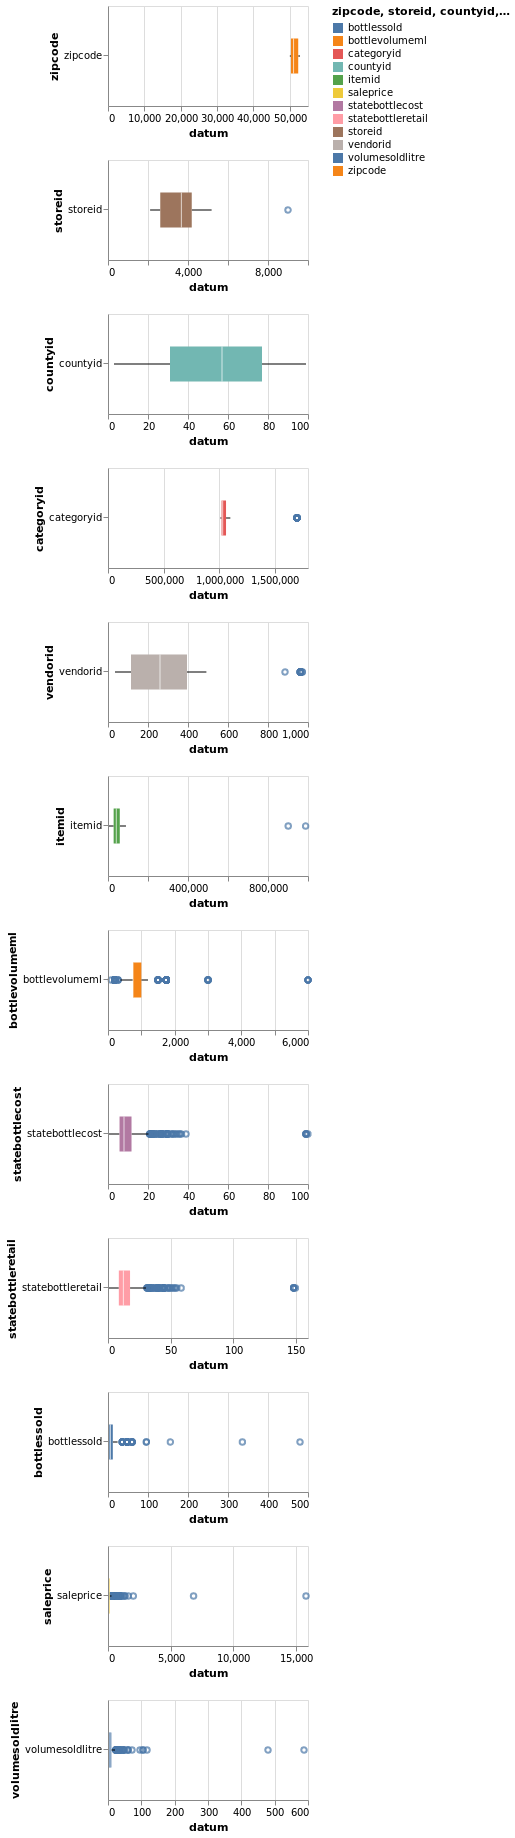

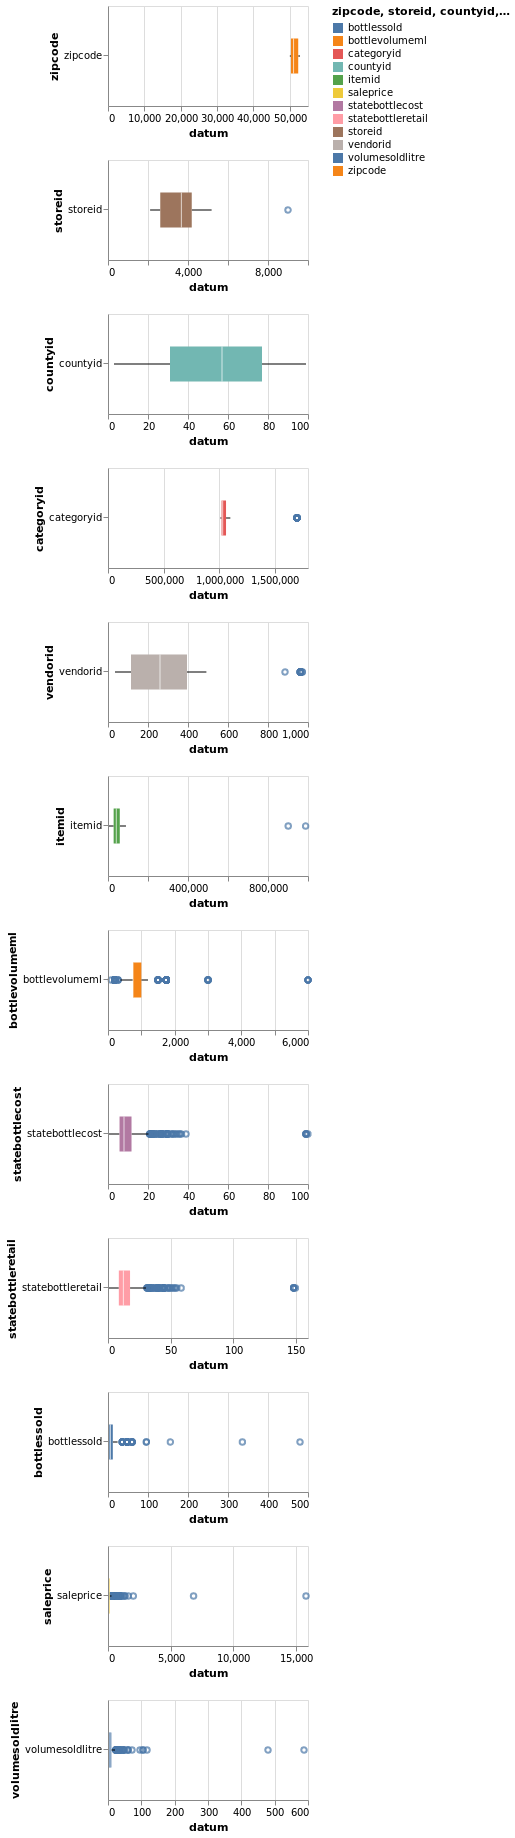

In [43]:
fL

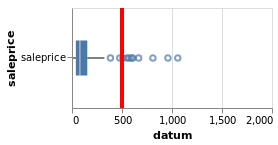

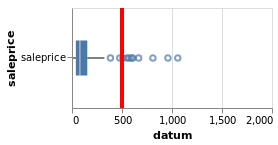

In [84]:
theData = df_ser(dfILS,"saleprice").head(200)
theData["markRule"] = 500

chart = alt.Chart(theData)

mainchart = chart.mark_boxplot(extent=1.5,size=35,clip=True).encode(
    y="saleprice:O",
    x=alt.X('datum:Q',scale=alt.Scale(domain=(1, 2000),zero=False))).properties(
    height=100, width=200).

lineBar = chart.mark_rule(color='red').encode(
    x='markRule:Q',
    size=alt.value(3)
)

mainchart + lineBar

All the things I need to do:
- try to do most of the data processing in the dataframe; avoid altairs various layers for now.
- scan the data pulled, and calculate Q1, Q3, Q2, and the k*IRQ.
- create a pseudo-dataframe, with these points. set at specific intervals.
- calculate the desired range of the boxplot.
- Filter the dataframe, and find out:
    - how many % outliers are on each side: Let a "Line" represent 10% or less.

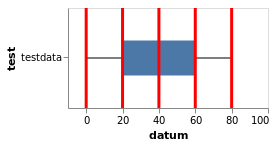

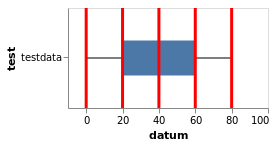

In [88]:
testDF = pd.DataFrame({"test":"testdata","datum":[0,20,40,60,80]})

testDF["lineCol"] = testDF["datum"]
chart = alt.Chart(testDF)

fChart = chart.mark_boxplot(extent=1.5,size=35).encode(
    y="test:O",
    x=alt.X('datum:Q',scale=alt.Scale(domain=(-10, 100),zero=False))).properties(
    height=100, width=200)

lineBar = chart.mark_rule(color='red').encode(
    x='lineCol:Q',
    size=alt.value(3)
)

fChart + lineBar

#It is possible to achieve!

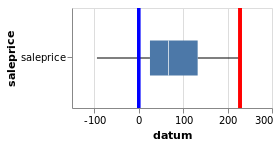

In [120]:
saleDF = dfILS["saleprice"]
qDict = {"min":saleDF.min(),
         "q0":0,
         "q1":saleDF.quantile(0.25),
         "q2":saleDF.median(),
         "q3":saleDF.quantile(0.75),
         "q4":0,
         "max":saleDF.max()}
qDict["q0"] = qDict["q2"] - 1.5*(qDict["q3"] - qDict["q1"])
qDict["q4"] = qDict["q2"] + 1.5*(qDict["q3"] - qDict["q1"])

pseudoDF = pd.DataFrame({"saleprice":"saleprice","datum":[qDict["q0"],qDict["q1"],qDict["q2"],qDict["q3"],qDict["q4"]]})

if (qDict["min"] < qDict["q0"]): #Draw a Red Line just outside of Q0
     pseudoDF["outlierL"] = qDict["q0"]
else:
    pseudoDF["min"] = qDict["min"]

if (qDict["max"] > qDict["q4"]): #Draw a Red Line just outside of Q4
    pseudoDF["outlierR"] = qDict["q4"]
else: #Draw a blue line for the maximum
    pseudoDF["max"] = qDict["q4"]

#Dataframe finished, make our chart.
chart = alt.Chart(pseudoDF)

#determine domain:
axisRange = (pseudoDF["datum"].iloc[4]- pseudoDF["datum"].iloc[0])
lower = pseudoDF["datum"].iloc[0] - axisRange*0.1
upper = pseudoDF["datum"].iloc[4] + axisRange*0.1

#make main chart
mainchart = chart.mark_boxplot(extent=1.5,size=35,clip=True).encode(
    y="saleprice:O",
    x=alt.X('datum:Q',scale=alt.Scale(domain=(lower, upper),zero=False))).properties(
    height=100, width=200)

#now lets determine the layers

lowerLine = 0
upperLine = 0

if "outlierL" in pseudoDF.columns:
    lowerLine = chart.mark_rule(color='red').encode(
    x='outlierL:Q',
    size=alt.value(3))    
if "min" in pseudoDF.columns:
    lowerLine = chart.mark_rule(color='blue').encode(
    x='min:Q',
    size=alt.value(3))

if "outlierR" in pseudoDF.columns:
    upperLine = chart.mark_rule(color='red').encode(
    x='outlierR:Q',
    size=alt.value(3))
if "max" in pseudoDF.columns:
    upperLine = chart.mark_rule(color='blue').encode(
    x='max:Q',
    size=alt.value(3))

mainchart + lowerLine + upperLine





,saleprice,datum,min,outlierR
0,saleprice,-93.825,0.0,228.105
1,saleprice,25.410,0.0,228.105
2,saleprice,67.140,0.0,228.105
3,saleprice,132.720,0.0,228.105
4,saleprice,228.105,0.0,228.105


In [16]:
#Signature: DataFrame, String -> DataFrame
#Purpose: Analyse a given numerical series. Construct a pseudo dataframe that mimics Q1,Q2,Q3 from series.
#add additional outlier/point information for Altair to interpret (in the prod_chart) method.
#Note: I assume 1.5*IRQ for the whiskers.
def df_gen(data,colname):
    df = data[colname]
    qDict = {"min":df.min(),
             "q0":0,
             "q1":df.quantile(0.25),
             "q2":df.median(),
             "q3":df.quantile(0.75),
             "q4":0,
             "max":df.max()}
    qDict["q0"] = qDict["q2"] - 1.5*(qDict["q3"] - qDict["q1"])
    qDict["q4"] = qDict["q2"] + 1.5*(qDict["q3"] - qDict["q1"])

    pseudoDF = pd.DataFrame({colname:colname,"datum":[qDict["q0"],qDict["q1"],qDict["q2"],qDict["q3"],qDict["q4"]]})

    if (qDict["min"] < qDict["q0"]): #Draw a Red Line just outside of Q0
         pseudoDF["outlierL"] = qDict["q0"]
    else:
        pseudoDF["min"] = qDict["min"]

    if (qDict["max"] > qDict["q4"]): #Draw a Red Line just outside of Q4
        pseudoDF["outlierR"] = qDict["q4"]
    else: #Draw a blue line for the maximum
        pseudoDF["max"] = qDict["max"]

    return pseudoDF

#Signature: String -> Boolean
#Check to see if a col type is in the given list.
def checklist(x):
    return (x in ["float32","float64","int16","int32","int64"]) #** Reasonable types? Corner Cases? 

def prod_chart(pseudoDF,colname):
    #Dataframe finished, make our chart.
    chart = alt.Chart(pseudoDF)

    #determine domain:
    axisRange = (pseudoDF["datum"].iloc[4]- pseudoDF["datum"].iloc[0])
    lower = pseudoDF["datum"].iloc[0] - axisRange*0.1
    upper = pseudoDF["datum"].iloc[4] + axisRange*0.1

    #make main chart
    mainChart = chart.mark_boxplot(extent=1.5,size=35,clip=True).encode(
        y=alt.Y(colname+":O",axis=alt.Axis(title=" ")),
        x=alt.X('datum:Q',
                scale=alt.Scale(domain=(lower, upper),zero=False),
                axis=alt.Axis(title=" "))).properties(
        height=100, width=400)

    #now lets determine the layers

    lowerLine = 0
    upperLine = 0

    if "outlierL" in pseudoDF.columns:
        lowerLine = chart.mark_rule(color='red').encode(
        x='outlierL:Q',
        size=alt.value(3))    
    if "min" in pseudoDF.columns:
        lowerLine = chart.mark_rule(color='blue').encode(
        x='min:Q',
        size=alt.value(3))

    if "outlierR" in pseudoDF.columns:
        upperLine = chart.mark_rule(color='red').encode(
        x='outlierR:Q',
        size=alt.value(3))
    if "max" in pseudoDF.columns:
        upperLine = chart.mark_rule(color='blue').encode(
        x='max:Q',
        size=alt.value(3))
        
    return (mainChart + lowerLine + upperLine)    

#Signature: DataFrame -> Chart
#Purpose: Extract all numerical columns form a data frame, and make a stacked bar chart for quick comparison
#of data rangers, outliers, bounds etc. This is a visual representation of the describe() method.

def boxplotblast(df):
    #first, identify numerical columns of dataframe
    dTypeSer = df.dtypes
    hold = dTypeSer.apply(checklist) #Ret bool selector
    numCols = df.columns[hold] #return index object; like an array/list
    finalChart = prod_chart(df_gen(df, numCols[0]),numCols[0]) #limit it for now!

    for i,item in enumerate(numCols[1:]):
        currChart = prod_chart(df_gen(df, item), item)
        finalChart = finalChart & currChart
    
    print("Guide: Blue lines indicate max/min value. Red Lines indicate cutoff of outliers.")
    
    return finalChart


Guide: Blue lines indicate max/min value. Red Lines indicate cutoff of outliers.


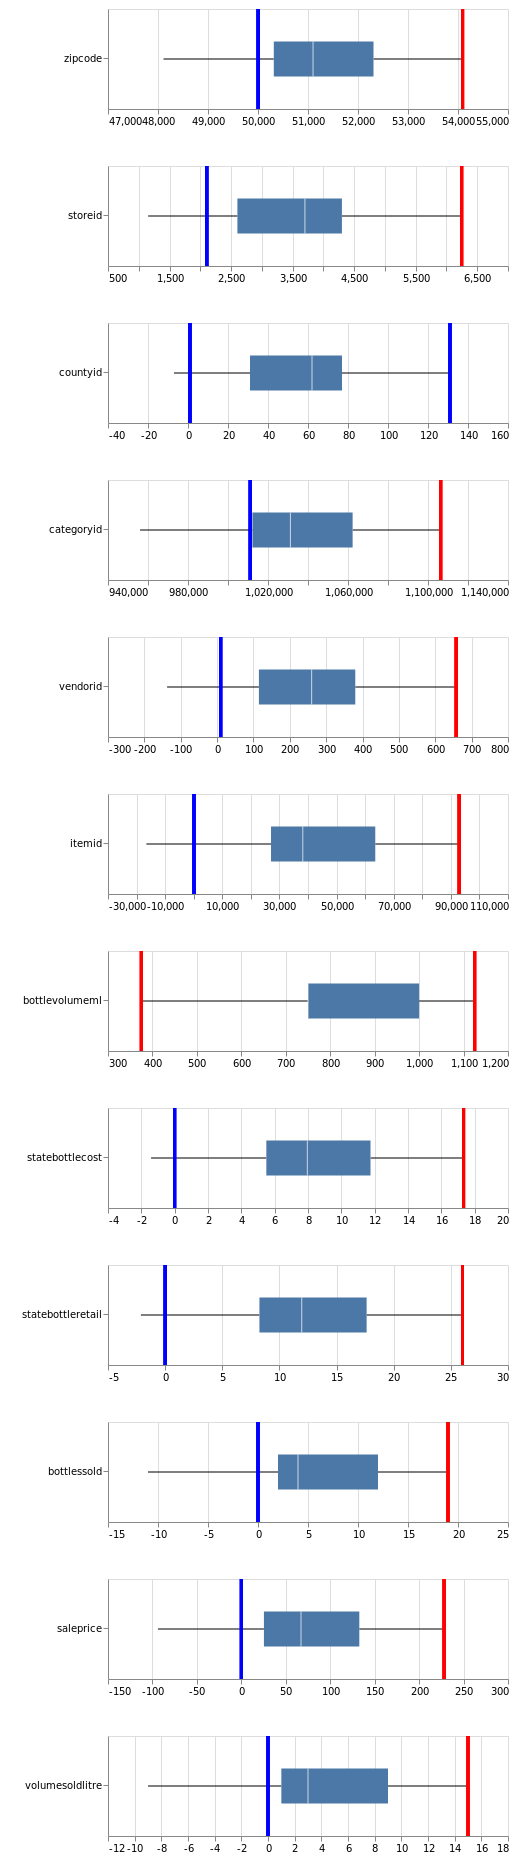

In [12]:
boxplotblast(dfILS) 


In [ ]:
- scan the data pulled, and calculate Q1, Q3, Q2, and the k*IRQ.
- create a pseudo-dataframe, with these points. set at specific intervals.
- calculate the desired range of the boxplot.
- Filter the dataframe, and find out:
    - how many % outliers are on each side: Let a "Line" represent 10% or less.

In [13]:
#Lets try another dataset, to see what happens
mtcars = pd.read_csv("./data/mtcars.csv")
mtcars.head()


,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [15]:
mtcars.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


Guide: Blue lines indicate max/min value. Red Lines indicate cutoff of outliers.


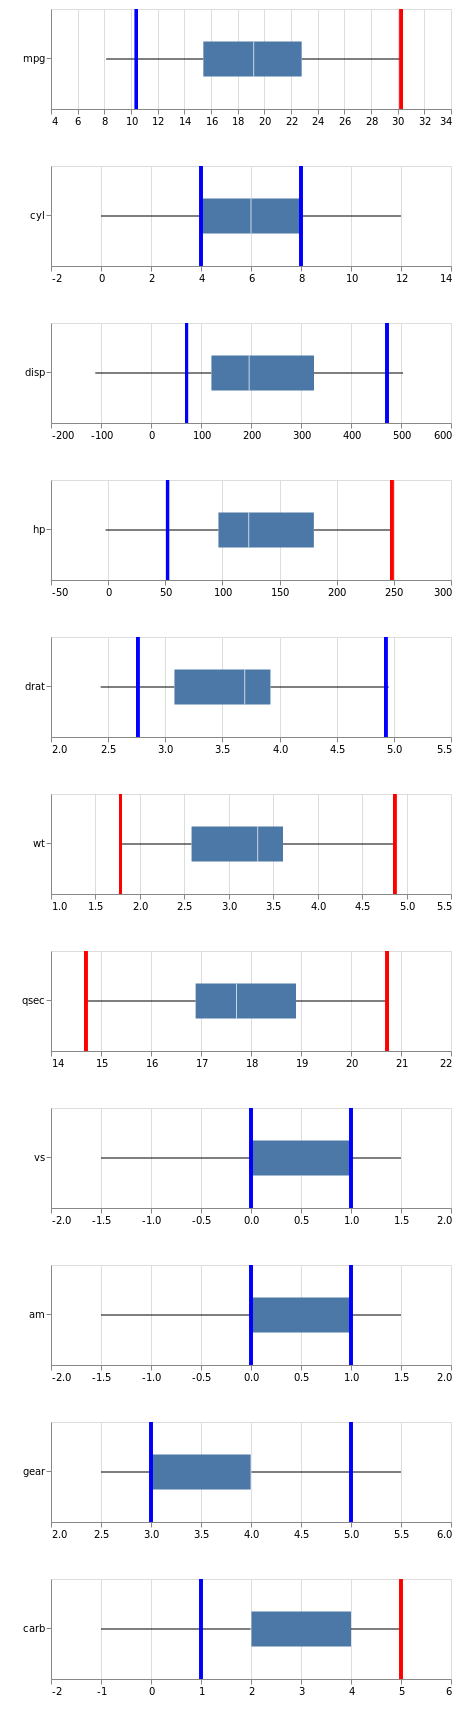

In [18]:
boxplotblast(mtcars)